In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import pandas as pd
import random
import scipy

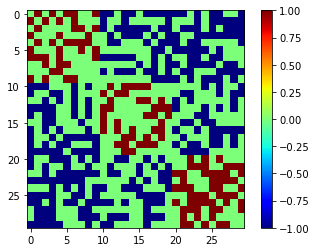

In [10]:
#function to return a signed stochastic block model (SSBM)

#number of nodes 
N = 30

#number of communities 
k = 3

#noise parameter (sign flip)
thresh = 1

#probability matrix - experiment with this, asymmetry gives interesting results 

#for a 3 community 
probs = [[0.5, 0.5, 0.5], [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]

def signed_SBM_parameters(N, k, probs, thresh): 
    clus_size = int(N/k)
    numbers = (np.ones(k)*clus_size).astype(int)
    #probs = (np.ones((k,k))*pval)
    
    G = nx.stochastic_block_model(numbers, probs)

    co = []
    
    for i in range(k):
        co.extend(np.ones(clus_size)*(i))

    for u,v in G.edges(): 
        if co[u] == co[v]:
            test = np.random.uniform(0,1)
            if test < thresh: 
           
                G.edges[u,v]["weight"] = 1
            else:
                G.edges[u,v]["weight"] = -1
        else:
            test = np.random.uniform(0,1)
            if test < thresh:
                G.edges[u,v]["weight"] = -1
            else: 
                G.edges[u,v]["weight"] = 1
                
    return G, co

G, co = signed_SBM_parameters(N, k, probs, thresh)

#look at the adjacecy matrix of this graph
plt.imshow(nx.to_numpy_array(G),cmap=plt.cm.jet)  
plt.colorbar()

In [11]:
#returns the repelling Laplacian of graph G (networkx graph object)
#the input should be an unweighted signed graph, but code can be changed to accept weighted graph 

def repelling_lap(G):

    selected_edges = [(u,v) for u,v in G.edges if G[u][v]['weight'] == -1]

    G_neg = nx.Graph()
    G_neg.add_nodes_from(G)
    G_neg.add_edges_from(selected_edges)
    degree_neg = [val for (node, val) in G_neg.degree()]
    D_neg = np.diag(degree_neg)

    selected_edges = [(u,v) for u,v in G.edges if G[u][v]['weight'] == 1]

    G_pos = nx.Graph()
    G_pos.add_nodes_from(G)
    G_pos.add_edges_from(selected_edges)
    degree_pos = [val for (node, val) in G_pos.degree()]
    D_pos = np.diag(degree_pos)
    
    A = nx.to_numpy_array(G)
    
    return D_pos - D_neg - A


#function to return null model of signed graph (keep toplogy, re-shuffle edge signs)

def null_graph_signed(G): 
    d = nx.get_edge_attributes(G, "weight")
    
    shuffled = list(d.values())
    random.shuffle(shuffled)
    shuf_signs = dict(zip(d, shuffled))
    
    H = nx.Graph()
    H.add_nodes_from(G)
    H.add_edges_from(G.edges)
    
    nx.set_edge_attributes(H, shuf_signs, "weight")   
    
    return H

In [12]:
#functions to help return the optimal dimension of the graph 

def dist(P):
    a = 0
    for i in range(k):
        a = a + (P[:,i]-P[:,i][:,np.newaxis])**2
    return np.sqrt(a)

#inputs P is the positions of the nodes (found using eigenvalues of repelling Laplacian) and A, the adjacency matrix of graph 
def energy_repelling_lap_norm(P,A):
    
    P = P.reshape((-1, k))
    D_un = dist(P)**2  
    norm = np.sqrt(np.sum(D_un**2))
    D = D_un/norm  
    
    energy = np.multiply(D, A).sum()

    return energy

10
(array([1]),)


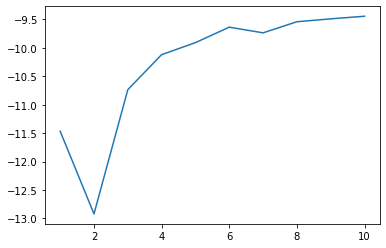

In [14]:
#get the repelling Laplacian of graph G 
Lr = repelling_lap(G)
A = nx.to_numpy_array(G)
val, vect = np.linalg.eigh(Lr)

#find the minimum of the dimension required 
k_max = 10
dims = np.arange(k_max) + 1
energy = []
for i in range(k_max):
    k = i + 1
    energy.append(energy_repelling_lap_norm(vect[:,0:k], A))
    if k%10 == 0: 
        print(k)
plt.plot(dims, energy)

print(np.where(energy == min(energy)))